In [52]:
import pandas as pd
data_original = pd.read_csv("data_final.csv")

data = data_original

# Select a specific search query
#data = data[data["search_query"].str.contains("2hollis type beat", na=False)]

query_counts = data["search_query"].value_counts()
print(query_counts)

search_query
2hollis type beat     252
nate sib type beat    193
hyperpop type beat    189
Name: count, dtype: int64


In [53]:
# Basic tag analysis (not very meaningful)
data_split = data
data_split["tags"] = data_split["tags"].str.split("|")
exploded = data.explode("tags")

# Calculate average views per tag
tag_stats = exploded.groupby("tags")["views"].mean().sort_values(ascending=False)

print(f"\nBased on {data.shape[0]} videos")
print(tag_stats)


Based on 634 videos
tags
tell em type beat                 1471189.0
free beat for profit              1471189.0
playboi carti untagged            1471189.0
cochise x snot type beat          1471189.0
free for frofit yeat type beat    1471189.0
                                    ...    
Free EDM Trap instrumental             11.0
2hollis x hpzbeatz collab              11.0
Emotional trap type beat               11.0
genre switch type beat                  0.0
trap x edm type beat                    0.0
Name: views, Length: 1645, dtype: float64


In [54]:
# Weighted tag analysis
total_videos = len(data)
print(f"Total number of videos: {total_videos}")

exploded = data_split.explode("tags")

tag_counts = exploded["tags"].value_counts()

print("Tag Occurrences:")
print(tag_counts.head())

# Filter tags by minimum frequency
MIN_COUNT = 5
filtered_exploded = exploded[exploded["tags"].isin(tag_counts[tag_counts >= MIN_COUNT].index)].copy()  # Make a copy here

# Calculate weighted average views
filtered_exploded["weight"] = filtered_exploded["tags"].map(tag_counts)
filtered_exploded["weighted_views"] = filtered_exploded["views"] * filtered_exploded["weight"]

tag_stats = (
    filtered_exploded.groupby("tags")
    .agg(weighted_avg_views=('weighted_views', 'sum'), total_weight=('weight', 'sum'))
    .reset_index()
)

# Calculate weighted average views for each tag
tag_stats["weighted_avg_views"] = tag_stats["weighted_avg_views"] / tag_stats["total_weight"]

# Sort by weighted average views
tag_stats = tag_stats.sort_values(by="weighted_avg_views", ascending=False)

print("\nWeighted Average Views per Tag:")
print(tag_stats.head(10))



Total number of videos: 634
Tag Occurrences:
tags
2hollis type beat     368
ericdoa type beat     276
midwxst type beat     253
hyperpop type beat    247
type beat             245
Name: count, dtype: int64

Weighted Average Views per Tag:
                          tags  weighted_avg_views  total_weight
1      100 gecs type beat free       379269.333333            36
252            p4rkr type beat       299578.714286            49
115  free for profit type beat       241790.900000           100
104    free 100 gecs type beat       235780.066667           225
117  free glitchcore type beat       228085.571429           196
185    hyperpop type beat 2021       195283.818182           121
229    miss the rage type beat       190720.142857            49
181     hyperpop edm type beat       178656.526316           361
251          osquinn type beat       166659.533333           225
62        charli xcx type beat       149608.750000           144


## Channel Investigation

In [55]:
# See which channels are occuring most and their average views

total_videos = len(data)
print(f"Total number of videos: {total_videos}")

# Count videos per channel
channel_counts = data["channel_name"].value_counts()

# Calculate percentage for each channel and round to 1 decimal
channel_percentage = (channel_counts / total_videos) * 100
channel_percentage = channel_percentage.round(1)

# Calculate average views per channel
average_views_per_channel = data.groupby("channel_name")["views"].mean()
average_views_per_channel = average_views_per_channel.round().astype(int)

channel_stats = pd.DataFrame({
    'video_count': channel_counts,
    'percentage': channel_percentage,
    'average_views': average_views_per_channel
})

# Sort by highest percentage first
channel_stats = channel_stats.sort_values(by="percentage", ascending=False)

print(query_counts)
print(channel_stats)


Total number of videos: 634
search_query
2hollis type beat     252
nate sib type beat    193
hyperpop type beat    189
Name: count, dtype: int64
                           video_count  percentage  average_views
channel_name                                                     
siem spark                          40         6.3          14283
tiresss / underrated club           38         6.0           9600
joalisho                            30         4.7           7031
dera                                21         3.3           7352
Klimlords Beats                     19         3.0          48288
...                                ...         ...            ...
wydastral                            1         0.2            669
x1lly                                1         0.2            256
x0_HellA                             1         0.2           8160
yngstarx                             1         0.2          11386
yukiidaruma! prod.                   1         0.2          468

Correlation between duration (in seconds) and views: 0.168


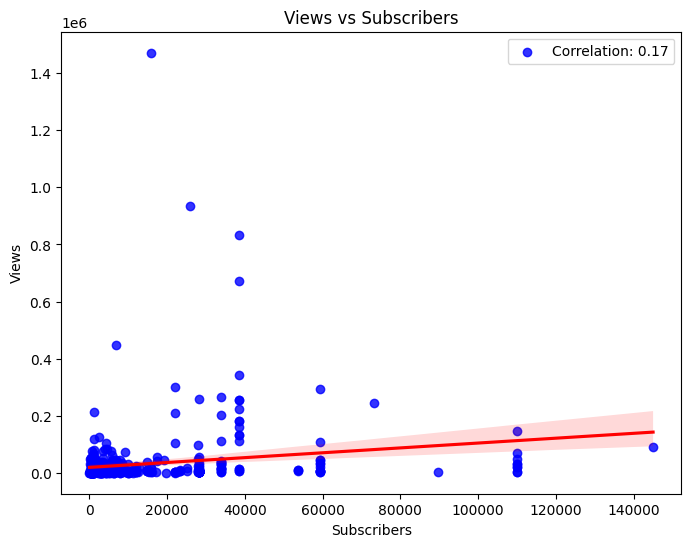

In [56]:
# Correlation between subscribers and views

data_subs = data[(data['views'] > 1000)] # You can change this threshold

correlation = data_subs["subscribers"].corr(data_subs["views"])
print(f"Correlation between duration (in seconds) and views: {correlation:.3f}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(data=data_subs, x="subscribers", y="views", scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

plt.title("Views vs Subscribers")
plt.xlabel("Subscribers")
plt.ylabel("Views")
plt.legend([f'Correlation: {correlation:.2f}'], loc='best')

plt.show()

## Title Research

In [58]:
# Compare "free" to "free for profit"

total_rows = len(data)

data["title_lower"] = data["title"].str.lower()

# Filter rows for each condition
free_rows = data[data["title_lower"].str.contains(r'\bfree\b(?! for profit)', regex=True)]
free_for_profit_rows = data[data["title_lower"].str.contains('free for profit')]
other_rows = data[~data["title_lower"].str.contains(r'\bfree\b', regex=True)]  # Exclude all "free"

# Calculate statistics for "free"
free_avg_views = free_rows['views'].mean()
free_std_views = free_rows['views'].std()
free_count = len(free_rows)
free_percentage = (free_count / total_rows) * 100

# Calculate statistics for "free for profit"
free_for_profit_avg_views = free_for_profit_rows['views'].mean()
free_for_profit_std_views = free_for_profit_rows['views'].std()
free_for_profit_count = len(free_for_profit_rows)
free_for_profit_percentage = (free_for_profit_count / total_rows) * 100

# Calculate statistics for "other"
other_avg_views = other_rows['views'].mean()
other_std_views = other_rows['views'].std()
other_count = len(other_rows)
other_percentage = (other_count / total_rows) * 100

summary_data = {
    "Average Views": [free_avg_views, free_for_profit_avg_views, other_avg_views],
    "Standard Deviation": [free_std_views, free_for_profit_std_views, other_std_views],
    "Count": [free_count, free_for_profit_count, other_count],
    "Percentage of Total (%)": [free_percentage, free_for_profit_percentage, other_percentage]
}

summary_df = pd.DataFrame(summary_data, index=['free', 'free for profit', 'other'])

summary_df = summary_df.T

# Round values
summary_df.loc['Average Views'] = summary_df.loc['Average Views'].round()
summary_df.loc['Standard Deviation'] = summary_df.loc['Standard Deviation'].round()
summary_df.loc['Count'] = summary_df.loc['Count'].astype(int)
summary_df.loc['Percentage of Total (%)'] = summary_df.loc['Percentage of Total (%)'].round(1)

print(summary_df)


                            free  free for profit    other
Average Views            23275.0          39039.0   9981.0
Standard Deviation       71145.0         164622.0  31633.0
Count                      357.0            122.0    155.0
Percentage of Total (%)     56.3             19.2     24.4


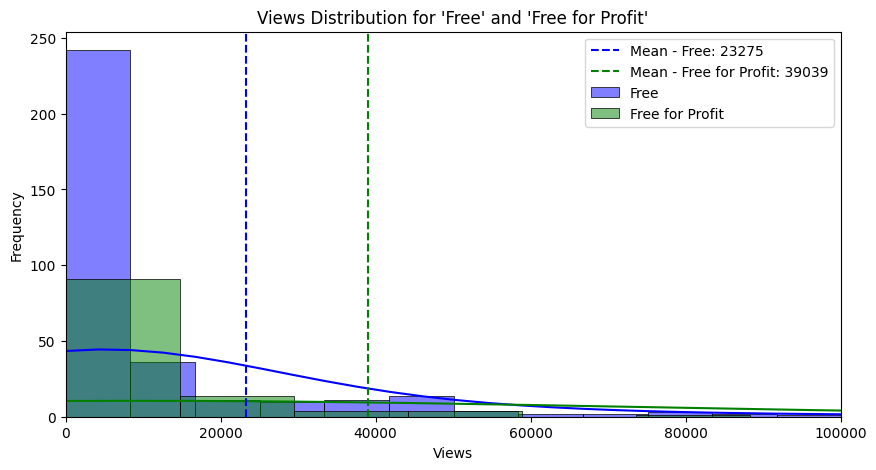

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate means for each group
free_mean = free_rows['views'].mean()
free_for_profit_mean = free_for_profit_rows['views'].mean()

# Histograms to visualize the distribution of views
plt.figure(figsize=(10, 5))

sns.histplot(free_rows['views'], kde=True, color='blue', label='Free', bins=100)
sns.histplot(free_for_profit_rows['views'], kde=True, color='green', label='Free for Profit', bins=100)

# Mean for "free"
plt.axvline(free_mean, color='blue', linestyle='--', label=f'Mean - Free: {free_mean:.0f}')

# Mean for "free for profit"
plt.axvline(free_for_profit_mean, color='green', linestyle='--', label=f'Mean - Free for Profit: {free_for_profit_mean:.0f}')

plt.legend()
plt.title("Views Distribution for 'Free' and 'Free for Profit'")
plt.xlabel("Views")
plt.xlim(0, 100000)
plt.ylabel("Frequency")
plt.show()


In [64]:
from scipy.stats import ttest_ind

# Perform the t-test
t_stat, p_value = ttest_ind(free_rows['views'], free_for_profit_rows['views'], equal_var=False)

# Print the results
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")


T-statistic: -1.025
P-value: 0.307


## Duration correlation with views

In [66]:
data_longform = data[data['duration_seconds'] > 60]

Correlation between duration and views: 0.095


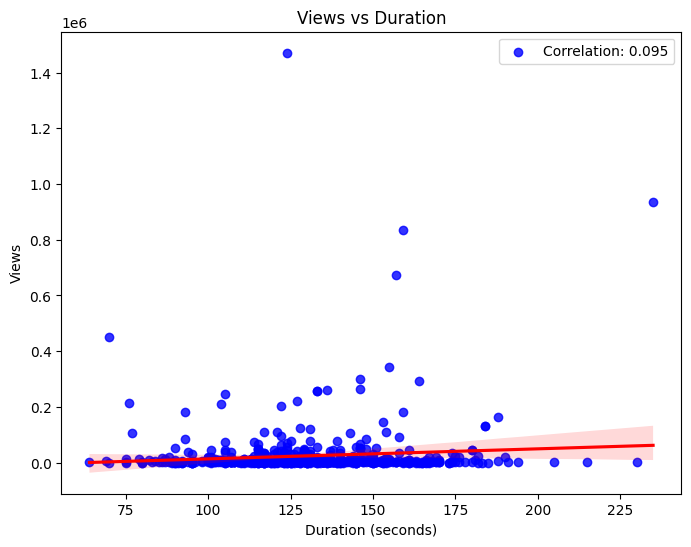

In [67]:
# Correlation duration with views
correlation = data_longform["duration_seconds"].corr(data_longform["views"])
print(f"Correlation between duration and views: {correlation:.3f}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(data=data_longform, x="duration_seconds", y="views", scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

plt.title("Views vs Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Views")
plt.legend([f'Correlation: {correlation:.3f}'], loc='best')

plt.show()

In [68]:
spearman_corr = data_longform["duration_seconds"].corr(data_longform["views"], method="spearman")
print(f"Spearman Correlation: {spearman_corr:.3f}")


Spearman Correlation: 0.014


Correlation between duration (in seconds) and views: 0.187


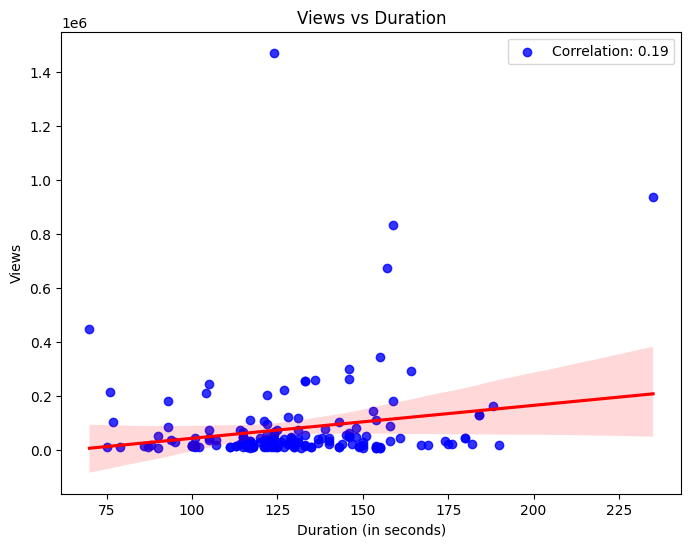

In [ ]:
# Correlation duration with views (higher views)
data_longform_highviews = data_longform[data_longform['views'] > 10000] # You can change this threshold

correlation = data_longform_highviews["duration_seconds"].corr(data_longform_highviews["views"])
print(f"Correlation between duration (in seconds) and views: {correlation:.3f}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(data=data_longform_highviews, x="duration_seconds", y="views", scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

plt.title("Views vs Duration")
plt.xlabel("Duration (in seconds)")
plt.ylabel("Views")
plt.legend([f'Correlation: {correlation:.2f}'], loc='best')

plt.show()